In [89]:
import pandas as pd
from string import ascii_uppercase as alphabet
import pickle


# Partie 1 : extracting tables from groups A-H

In [97]:
all_tables = pd.read_html('https://web.archive.org/web/20221115040351/https://en.wikipedia.org/wiki/2022_FIFA_World_Cup')

In [98]:
all_tables[12]
all_tables[19]
all_tables[26]
all_tables[61]

,Pos,Teamvte,Pld,W,D,L,GF,GA,GD,Pts,Qualification
0,1,Portugal,0,0,0,0,0,0,0,0,Advance to knockout stage
1,2,Ghana,0,0,0,0,0,0,0,0,Advance to knockout stage
2,3,Uruguay,0,0,0,0,0,0,0,0,NaN
3,4,South Korea,0,0,0,0,0,0,0,0,NaN


In [101]:
all_tables = pd.read_html('https://web.archive.org/web/20221115040351/https://en.wikipedia.org/wiki/2022_FIFA_World_Cup')

dict_table = {}
for letter, i in zip(alphabet, range(12,68,7)):
    df = all_tables[i]
    df.rename(columns={'Teamvte': 'Team'}, inplace=True)   #je change le nom pour Team au lieu de Teamvte
    df.pop('Qualification')   # je ne veux pas de la colonne qualif car c est ce que je vais prédire
    dict_table[f'Group {letter}'] = df 


In [102]:
all_tables[19].columns[1]

'Team'

In [105]:
dict_table.keys()

dict_keys(['Group A', 'Group B', 'Group C', 'Group D', 'Group E', 'Group F', 'Group G', 'Group H'])

In [107]:
dict_table['Group A']

,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts
0,1,Qatar (H),0,0,0,0,0,0,0,0
1,2,Ecuador,0,0,0,0,0,0,0,0
2,3,Senegal,0,0,0,0,0,0,0,0
3,4,Netherlands,0,0,0,0,0,0,0,0


In [109]:
with open('dict_table', 'wb') as output: 
    pickle.dump(dict_table, output)

#  Partie 2 : extracting Football matches

In [24]:
!pip install bs4

In [112]:
from bs4 import BeautifulSoup
import requests
import pandas as pd


In [ ]:
years=  [1930, 1934, 1938, 1950, 1954, 1958, 1962, 1966, 1970, 1974, 1978, 1982, 1986, 1994, 1998, 2006, 2010, 2014, 1982, 1986, 1990, 1994, 1998, 2002, 2006, 2010, 2014, 2018]


def get_matches(year):
    web = f'https://en.wikipedia.org/wiki/{year}_FIFA_World_Cup'  # f string permet de changer l'année ici dans l'url
    response = requests.get(web)
    content = response.text
    soup = BeautifulSoup(content, 'lxml')

    matches = soup.find_all('div', class_='footballbox')


    home = []
    score = []
    away = []


    for match in matches:
        home.append(match.find('th', class_='fhome').get_text())
        score.append(match.find('th', class_='fscore').get_text())
        away.append(match.find('th', class_='faway').get_text())


    dict_football = {'home': home, 'score':score, 'away': away}
    df_football = pd.DataFrame(dict_football)
    df_football['year']= year

    return df_football


fifa = [get_matches(year) for year in years]
df_fifa = pd.concat(fifa, ignore_index=True)

df_fifa.to_csv('fifa_worldcup_historical_data.csv', index= False)

# ici on se place dans un ancien wiki dans le cas ou la CDM 2022 n'a pas encore eu lieu sauf que ca ne marche pas donc on prend le jeux de données sans les résultats
df_fixture= get_matches(2022)
df_fixture.to_csv('fifa_worldcup_fixture_results.csv', index= False)




# On va chercher les data manquantes

In [41]:
!pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 1.7 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 343.0 kB/s eta 0:00:00--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.8/129.8 kB 899.5 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 779.2 kB/s eta 0:00:000:00:01
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
  Attempting uninstall: attrs
    Found existing installation: attrs 23.1.0
    Uninstalling attrs-23.1.0:
      Successfully uninstalled attrs-23.1.0
ERROR: pip's dependency resolver does not currently take i

In [56]:
!pip install webdriver_manager

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time
import pandas as pd

# Création du driver avec webdriver-manager (pas besoin de chemin manuel)
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)

def get_missing_data(year):
    web = f'https://en.wikipedia.org/wiki/{year}_FIFA_World_Cup'

    driver.get(web)
    matches = driver.find_elements(
        by='xpath',
        value='//td[@align="right"]/.. | //td[@style="text-align:right;"]/..'
    )

    home = []
    score = []
    away = []

    for match in matches:
        home.append(match.find_element(by='xpath', value='./td[1]').text)
        score.append(match.find_element(by='xpath', value='./td[2]').text)
        away.append(match.find_element(by='xpath', value='./td[3]').text)

    dict_football = {'home': home, 'score': score, 'away': away}
    df_football = pd.DataFrame(dict_football)
    df_football['year'] = year
    time.sleep(2)
    return df_football

years = [
    1930, 1934, 1938, 1950, 1954, 1958, 1962, 1966, 1970, 1974,
    1978, 1982, 1986, 1990, 1994, 1998, 2002, 2006, 2010, 2014,
    2018
]

fifa = [get_missing_data(year) for year in years]
driver.quit()

df_fifa = pd.concat(fifa, ignore_index=True)
df_fifa.to_csv("fifa_worldcup_missing_data.csv", index=False)


# Partie 3 : Data cleaning and transformation


In [117]:
df_historical_data = pd.read_csv('fifa_worldcup_historical_data.csv')
df_fixture = pd.read_csv('fifa_worldcup_fixture.csv')
df_missing_data = pd.read_csv('fifa_worldcup_missing_data.csv')

In [129]:
df_fixture['home'] = df_fixture['home'].str.strip()
df_fixture['away']= df_fixture['away'].str.strip()

In [137]:
df_missing_data[df_missing_data['home'].isnull()]

,home,score,away,year
36,NaN,NaN,NaN,2010
37,NaN,NaN,NaN,2010
38,NaN,NaN,NaN,2010
39,NaN,NaN,NaN,2010
40,NaN,NaN,NaN,2010
...,...,...,...,...
95,NaN,NaN,NaN,2010
96,NaN,NaN,NaN,2010
97,NaN,NaN,NaN,2010
98,NaN,NaN,NaN,2010


In [139]:
df_missing_data.dropna(inplace=True)

In [143]:
df_missing_data[df_missing_data['home'].isnull()] # c est ok on a plus de Na dans a table

,home,score,away,year


In [147]:
df_historical_data = pd.concat([df_missing_data, df_historical_data], ignore_index=True)
df_historical_data.drop_duplicates(inplace=True)
df_historical_data.sort_values('year', inplace=True)
df_historical_data

,home,score,away,year
37,France,4–1,Mexico,1930
52,Uruguay,4–2,Argentina,1930
51,Uruguay,6–1,Yugoslavia,1930
50,Argentina,6–1,United States,1930
49,Uruguay,1–0,Peru,1930
...,...,...,...,...
899,Russia,2–2 (a.e.t.),Croatia,2018
900,France,1–0,Belgium,2018
901,South Korea,1–2,Mexico,2018
903,Sweden,1–0,South Korea,2018


In [151]:
# deleting match with walk over
delete_index = df_historical_data[df_historical_data['home'].str.contains('Sweden') &
                                  df_historical_data['away'].str.contains('Austria')].index

df_historical_data.drop(index=delete_index, inplace=True)

# cleanning score and home/away columns
df_historical_data['score'] = df_historical_data['score'].str.replace('[^\d–]', '', regex=True)
df_historical_data['home'] = df_historical_data['home'].str.strip() # clean blank spaces: Yugoslavia twice
df_historical_data['away'] = df_historical_data['away'].str.strip()

# splitting score columns into home and away goals and dropping score column
df_historical_data[['HomeGoals', 'AwayGoals']] = df_historical_data['score'].str.split('–', expand=True)
df_historical_data.drop('score', axis=1, inplace=True)

# renaming columns and changing data types
df_historical_data.rename(columns={'home': 'HomeTeam', 'away': 'AwayTeam', 
                                   'year':'Year'}, inplace=True)
df_historical_data = df_historical_data.astype({'HomeGoals': int, 'AwayGoals':int, 'Year': int})

# creating new column "totalgoals"
df_historical_data['TotalGoals'] = df_historical_data['HomeGoals'] + df_historical_data['AwayGoals']
df_historical_data

,HomeTeam,AwayTeam,Year,HomeGoals,AwayGoals,TotalGoals
37,France,Mexico,1930,4,1,5
52,Uruguay,Argentina,1930,4,2,6
51,Uruguay,Yugoslavia,1930,6,1,7
50,Argentina,United States,1930,6,1,7
49,Uruguay,Peru,1930,1,0,1
...,...,...,...,...,...,...
899,Russia,Croatia,2018,2,2,4
900,France,Belgium,2018,1,0,1
901,South Korea,Mexico,2018,1,2,3
903,Sweden,South Korea,2018,1,0,1


In [153]:
df_historical_data.to_csv('clean_fifa_worldcup_matches.csv',index=False)
df_fixture.to_csv('clean_fifa_worldcup_fixture.csv',index=False)

In [155]:
# verify number of matches per competition
years = [1930, 1934, 1938, 1950, 1954, 1958, 1962, 1966, 1970, 1974,
         1978, 1982, 1986, 1990, 1994, 1998, 2002, 2006, 2010, 2014,
         2018]

for year in years:
    print(year, len(df_historical_data[df_historical_data['Year']==year]))

1930 18
1934 17
1938 18
1950 22
1954 26
1958 35
1962 32
1966 32
1970 32
1974 38
1978 38
1982 52
1986 52
1990 52
1994 52
1998 64
2002 64
2006 64
2010 64
2014 64
2018 64


In [157]:
# verify data collected for a team
print(df_historical_data[df_historical_data['HomeTeam'].str.contains('Turkey')])
print(df_historical_data[df_historical_data['AwayTeam'].str.contains('Turkey')])

    HomeTeam     AwayTeam  Year  HomeGoals  AwayGoals  TotalGoals
128   Turkey  South Korea  1954          7          0           7
667   Turkey        China  2002          3          0           3
         HomeTeam AwayTeam  Year  HomeGoals  AwayGoals  TotalGoals
131  West Germany   Turkey  1954          4          1           5
127  West Germany   Turkey  1954          7          2           9
663        Brazil   Turkey  2002          2          1           3
665    Costa Rica   Turkey  2002          1          1           2
644   South Korea   Turkey  2002          2          3           5
643        Brazil   Turkey  2002          1          0           1
641       Senegal   Turkey  2002          0          1           1
637         Japan   Turkey  2002          0          1           1


# Partie 3 Data Visualisation

In [163]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

In [167]:
# nation_position, club_position, player_positions
df = pd.read_csv('players_22.csv', low_memory=False)

# selecting column
df = df[['short_name', 'age', 'nationality_name', 'overall', 'potential',
         'club_name', 'value_eur', 'wage_eur', 'player_positions']]

# selecting only one position
df['player_positions'] = df['player_positions'].str.split(',', expand=True)[0]

# dropping nan
df.dropna(inplace=True)

players_missing_worldcup = ['K. Benzema', 'S. Mané', 'S. Agüero', 'Sergio Ramos', 'P. Pogba',
                            'M. Reus', 'Diogo Jota', 'A. Harit', 'N. Kanté', 'G. Lo Celso', 'Piqué']

# dropping injured players
drop_index = df[df['short_name'].isin(players_missing_worldcup)].index
df.drop(drop_index, axis=0, inplace=True)
teams_worldcup = [
    'Qatar', 'Brazil', 'Belgium', 'France', 'Argentina', 'England', 'Spain', 'Portugal',
    'Mexico', 'Netherlands', 'Denmark', 'Germany', 'Uruguay', 'Switzerland', 'United States', 'Croatia',
    'Senegal', 'Iran', 'Japan', 'Morocco', 'Serbia', 'Poland', 'South Korea', 'Tunisia',
    'Cameroon', 'Canada', 'Ecuador', 'Saudi Arabia', 'Ghana', 'Wales', 'Costa Rica', 'Australia'
]

# filtering only national teams in the world cup
df = df[df['nationality_name'].isin(teams_worldcup)]
# best players
df.sort_values(by=['overall', 'potential', 'value_eur'], ascending=False, inplace=True)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


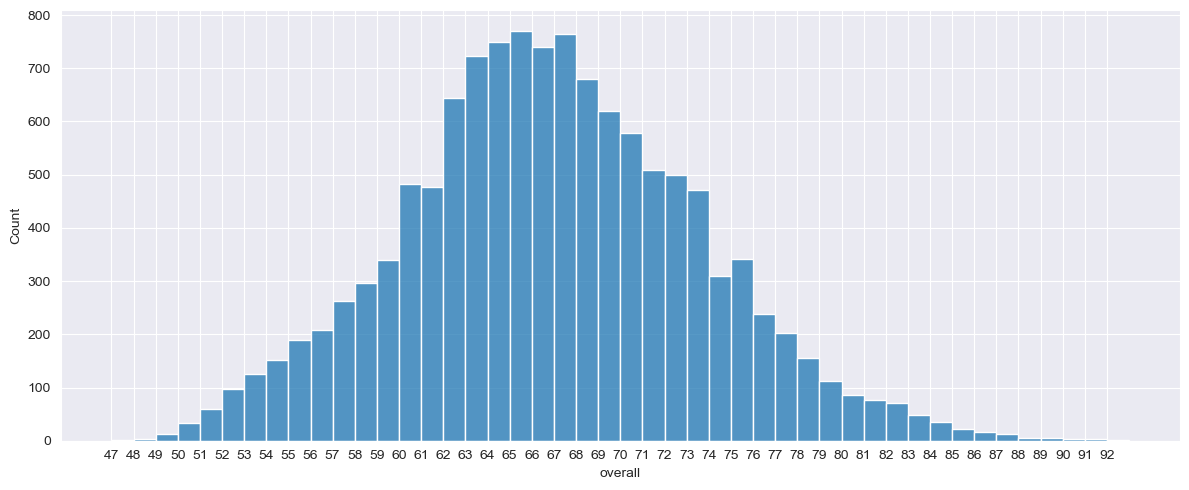

In [169]:
import numpy as np
fig, ax = plt.subplots(figsize=(12, 5), tight_layout=True)

sns.histplot(df, x='overall', binwidth=1)

bins = np.arange(df['overall'].min(), df['overall'].max(), 1)
plt.xticks(bins)
plt.show()

In [171]:
df.drop_duplicates('player_positions')


,short_name,age,nationality_name,overall,potential,club_name,value_eur,wage_eur,player_positions
0,L. Messi,34,Argentina,93,93,Paris Saint-Germain,78000000.0,320000.0,RW
1,R. Lewandowski,32,Poland,92,92,FC Bayern München,119500000.0,270000.0,ST
3,Neymar Jr,29,Brazil,91,91,Paris Saint-Germain,129000000.0,270000.0,LW
4,K. De Bruyne,30,Belgium,91,91,Manchester City,125500000.0,350000.0,CM
8,M. ter Stegen,29,Germany,90,92,FC Barcelona,99000000.0,250000.0,GK
19,J. Kimmich,26,Germany,89,90,FC Bayern München,108000000.0,160000.0,CDM
15,V. van Dijk,29,Netherlands,89,89,Liverpool,86000000.0,230000.0,CB
28,Bruno Fernandes,26,Portugal,88,89,Manchester United,107500000.0,250000.0,CAM
44,T. Alexander-Arnold,22,England,87,92,Liverpool,114000000.0,150000.0,RB
45,J. Sancho,21,England,87,91,Manchester United,116500000.0,150000.0,RM


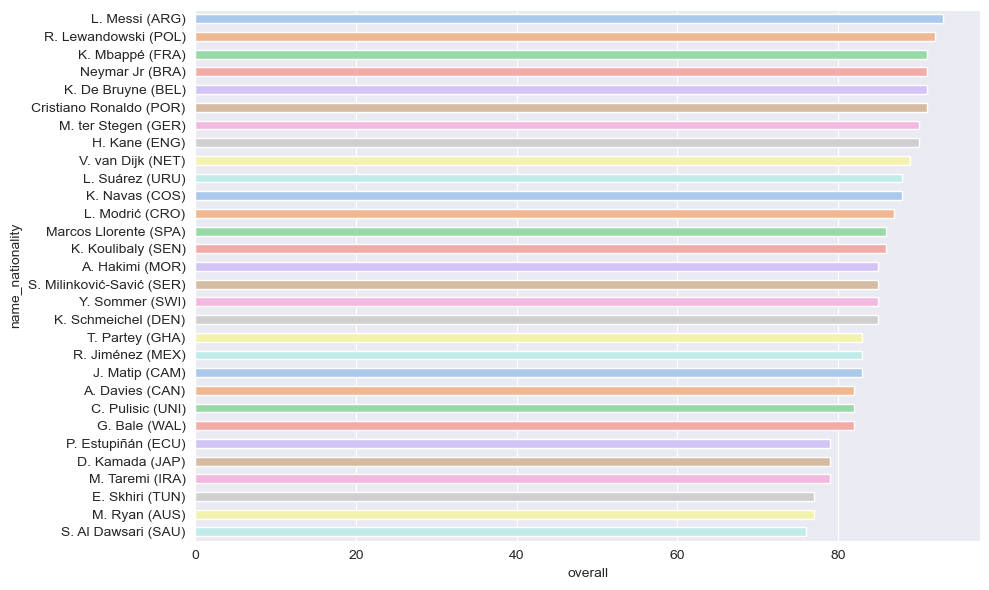

In [173]:
df_best_players = df.copy()
df_best_players = df_best_players.drop_duplicates('nationality_name').reset_index(drop=True)
country_short =  df_best_players['nationality_name'].str.extract('(^\w{3})', expand=False).str.upper()
df_best_players['name_nationality'] = df_best_players['short_name'] +' (' + country_short + ')'

fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)

sns.barplot(df_best_players, x='overall', y='name_nationality',
            palette=sns.color_palette('pastel'), width=0.5)
plt.show()

In [179]:
def best_squad(nationality):
    df_best_squad = df.copy()
    df_best_squad = df_best_squad.groupby(['nationality_name', 'player_positions']).head(2)
    df_best_squad = df_best_squad[df_best_squad['nationality_name']==nationality].sort_values(['player_positions', 'overall', 'potential'], ascending=False)
    return df_best_squad

In [209]:
df_bestFrance = best_squad('France')

In [213]:
df_bestFranceSorted_sorted = df_bestFrance.sort_values(by="overall", ascending=False)
df_bestFranceSorted_sorted

,short_name,age,nationality_name,overall,potential,club_name,value_eur,wage_eur,player_positions
6,K. Mbappé,22,France,91,95,Paris Saint-Germain,194000000.0,230000.0,ST
31,H. Lloris,34,France,87,87,Tottenham Hotspur,13500000.0,125000.0,GK
64,K. Coman,25,France,86,87,FC Bayern München,81000000.0,120000.0,LM
57,R. Varane,28,France,86,88,Manchester United,68500000.0,180000.0,CB
83,A. Griezmann,30,France,85,85,Atlético de Madrid,53000000.0,220000.0,ST
131,N. Fekir,27,France,84,84,Real Betis Balompié,45000000.0,42000.0,CAM
127,M. Maignan,25,France,84,89,AC Milan,49500000.0,45000.0,GK
111,L. Digne,27,France,84,84,Everton,40500000.0,110000.0,LB
137,T. Hernández,23,France,84,90,AC Milan,62500000.0,51000.0,LB
197,J. Koundé,22,France,83,89,Sevilla FC,53000000.0,33000.0,CB


In [217]:
df_bestFranceSorted_sorted_potential = df_bestFrance.sort_values(by="potential", ascending=False)
df_bestFranceSorted_sorted_potential

,short_name,age,nationality_name,overall,potential,club_name,value_eur,wage_eur,player_positions
6,K. Mbappé,22,France,91,95,Paris Saint-Germain,194000000.0,230000.0,ST
137,T. Hernández,23,France,84,90,AC Milan,62500000.0,51000.0,LB
197,J. Koundé,22,France,83,89,Sevilla FC,53000000.0,33000.0,CB
127,M. Maignan,25,France,84,89,AC Milan,49500000.0,45000.0,GK
382,M. Diaby,21,France,81,88,Bayer 04 Leverkusen,52500000.0,52000.0,LW
57,R. Varane,28,France,86,88,Manchester United,68500000.0,180000.0,CB
192,O. Dembélé,24,France,83,88,FC Barcelona,55000000.0,165000.0,RW
31,H. Lloris,34,France,87,87,Tottenham Hotspur,13500000.0,125000.0,GK
64,K. Coman,25,France,86,87,FC Bayern München,81000000.0,120000.0,LM
277,T. Ndombele,24,France,82,87,Tottenham Hotspur,46000000.0,95000.0,CAM


In [219]:
average_overall = [best_squad(team)['overall'].mean() for team in teams_worldcup]

df_average_overall = pd.DataFrame({'Teams': teams_worldcup, 'AVG_Overall': average_overall})
df_average_overall = df_average_overall.dropna()
df_average_overall = df_average_overall.sort_values('AVG_Overall', ascending=False)
df_average_overall

,Teams,AVG_Overall
6,Spain,82.400000
7,Portugal,81.733333
5,England,81.700000
1,Brazil,81.666667
3,France,81.000000
4,Argentina,80.566667
11,Germany,80.433333
2,Belgium,79.034483
9,Netherlands,78.758621
8,Mexico,77.727273


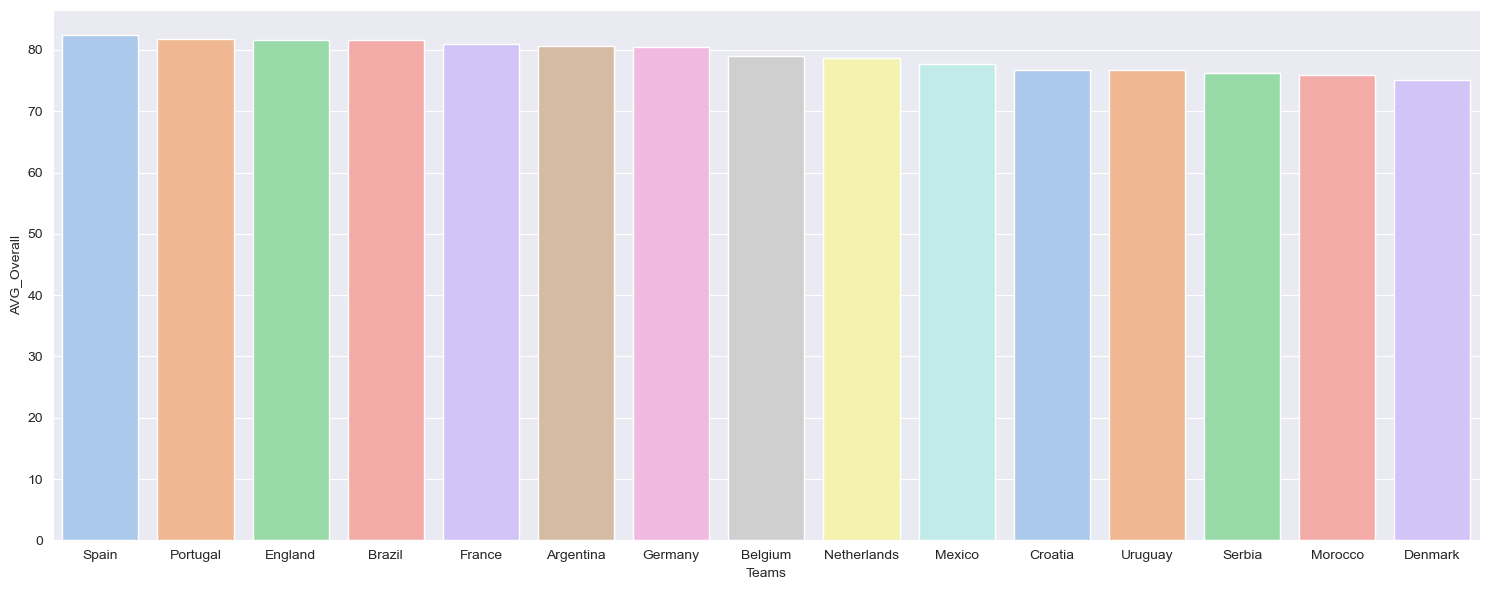

In [243]:
fig, ax = plt.subplots(figsize=(15, 6), tight_layout=True)

sns.barplot(df_average_overall[:15], x='Teams', y='AVG_Overall',
            palette=sns.color_palette('pastel'))
plt.show()

In [245]:
def best_lineup(nationality, lineup):
    lineup_count = [lineup.count(i) for i in lineup]

    df_lineup = pd.DataFrame({'position': lineup, 'count': lineup_count})
    positions_non_repeated = df_lineup[df_lineup['count'] <= 1]['position'].values
    positions_repeated = df_lineup[df_lineup['count'] > 1]['position'].values

    df_squad = best_squad(nationality)

    df_lineup = pd.concat([
        df_squad[df_squad['player_positions'].isin(positions_non_repeated)].drop_duplicates('player_positions', keep='first'),
        df_squad[df_squad['player_positions'].isin(positions_repeated)]]
    )
    return df_lineup[['short_name', 'overall', 'club_name', 'player_positions']]

In [247]:
dict_formation = {
    '4-3-3': ['GK', 'RB', 'CB', 'CB', 'LB', 'CDM', 'CM', 'CAM', 'RW', 'ST', 'LW'],
    '4-4-2': ['GK', 'RB', 'CB', 'CB', 'LB', 'RM', 'CM', 'CM', 'LM', 'ST', 'ST'],
    '4-2-3-1': ['GK', 'RB', 'CB', 'CB', 'LB', 'CDM', 'CDM', 'CAM', 'CAM', 'CAM', 'ST'],
}

In [249]:
for index, row in df_average_overall[:9].iterrows():
    max_average = None
    for key, values in dict_formation.items():
        average = best_lineup(row['Teams'], values)['overall'].mean()
        if max_average is None or average>max_average:
            max_average = average
            formation = key
    print(row['Teams'], formation, max_average)

Spain 4-2-3-1 85.1
Portugal 4-2-3-1 84.9
England 4-4-2 84.45454545454545
Brazil 4-3-3 84.81818181818181
France 4-2-3-1 83.9
Argentina 4-3-3 83.54545454545455
Germany 4-2-3-1 84.1
Belgium 4-3-3 82.54545454545455
Netherlands 4-4-2 82.54545454545455


In [253]:
# best_lineup('Spain', dict_formation['4-2-3-1'])
# best_lineup('Argentina', dict_formation['4-3-3'])
# best_lineup('Brazil', dict_formation['4-3-3'])
best_lineup('France', dict_formation['4-2-3-1'])

,short_name,overall,club_name,player_positions
6,K. Mbappé,91,Paris Saint-Germain,ST
621,B. Pavard,79,FC Bayern München,RB
137,T. Hernández,84,AC Milan,LB
31,H. Lloris,87,Tottenham Hotspur,GK
229,J. Veretout,82,Roma,CDM
301,B. André,81,LOSC Lille,CDM
57,R. Varane,86,Manchester United,CB
197,J. Koundé,83,Sevilla FC,CB
131,N. Fekir,84,Real Betis Balompié,CAM
277,T. Ndombele,82,Tottenham Hotspur,CAM


## Partie 4 : Prédiction CDM

In [63]:
!pip install scipy

import pandas as pd
import pickle
from scipy.stats import poisson



In [65]:
dict_table = pickle.load(open('dict_table','rb'))
df_historical_data = pd.read_csv('clean_fifa_worldcup_matches.csv')
df_fixture = pd.read_csv('clean_fifa_worldcup_fixture.csv')

df_historical_data

,HomeTeam,AwayTeam,Year,HomeGoals,AwayGoals,TotalGoals
0,France,Mexico,1930,4,1,5
1,Uruguay,Argentina,1930,4,2,6
2,Uruguay,Yugoslavia,1930,6,1,7
3,Argentina,United States,1930,6,1,7
4,Uruguay,Peru,1930,1,0,1
...,...,...,...,...,...,...
895,Russia,Croatia,2018,2,2,4
896,France,Belgium,2018,1,0,1
897,South Korea,Mexico,2018,1,2,3
898,Sweden,South Korea,2018,1,0,1


In [67]:
# Claculate Team strength

#Split df into df_home and df_away
df_home = df_historical_data[['HomeTeam', 'HomeGoals', 'AwayGoals']]
df_away = df_historical_data[['AwayTeam', 'HomeGoals', 'AwayGoals']]

In [69]:
df_home = df_home.rename(columns={'HomeTeam':'Team', 'HomeGoals':'GoalsScored', 'AwayGoals':'GoalsConceded'})
df_away = df_away.rename(columns={'AwayTeam':'Team', 'HomeGoals':'GoalsConceded', 'AwayGoals':'GoalsScored'})

In [89]:
df_team_strength = pd.concat([df_home,df_away], ignore_index=True).groupby('Team').mean()
df_team_strength

,GoalsScored,GoalsConceded
Team,,
Algeria,1.000000,1.461538
Angola,0.333333,0.666667
Argentina,1.691358,1.148148
Australia,0.812500,1.937500
Austria,1.482759,1.620690
...,...,...
Uruguay,1.553571,1.321429
Wales,0.800000,0.800000
West Germany,2.112903,1.241935


In [91]:
def predict_points(home, away):
    if home in df_team_strength.index and away in df_team_strength.index:
        # goals_scored * goals_conceded
        lamb_home = df_team_strength.at[home,'GoalsScored'] * df_team_strength.at[away,'GoalsConceded']
        lamb_away = df_team_strength.at[away,'GoalsScored'] * df_team_strength.at[home,'GoalsConceded']
        prob_home, prob_away, prob_draw = 0, 0, 0
        for x in range(0,11): #number of goals home team
            for y in range(0, 11): #number of goals away team
                p = poisson.pmf(x, lamb_home) * poisson.pmf(y, lamb_away)
                if x == y:
                    prob_draw += p
                elif x > y:
                    prob_home += p
                else:
                    prob_away += p
        
        points_home = 3 * prob_home + prob_draw
        points_away = 3 * prob_away + prob_draw
        return (points_home, points_away)
    else:
        return (0, 0)

In [101]:
# Tests 
predict_points('Argentina', 'Mexico')

(2.3129151525530505, 0.5378377125059863)

In [103]:
predict_points('England', 'United States')

(2.2356147635326007, 0.5922397535606193)

In [97]:
predict_points('Qatar (H)', 'Equador')

(0, 0)

In [ ]:
# logical as first time for Qatar

## Group Stage 

In [106]:
df_fixture_group_48 = df_fixture[:48].copy()
df_fixture_knockout = df_fixture[48:56].copy()
df_fixture_quarter = df_fixture[56:60].copy()
df_fixture_semi = df_fixture[60:62].copy()
df_fixture_final = df_fixture[62:].copy()

In [110]:
for group in dict_table:
    teams_in_group = dict_table[group]['Team'].values
    df_fixture_group_6 = df_fixture_group_48[df_fixture_group_48['home'].isin(teams_in_group)]
    for index, row in df_fixture_group_6.iterrows():
        home, away = row['home'], row['away']
        points_home, points_away = predict_points(home, away)
        dict_table[group].loc[dict_table[group]['Team'] == home, 'Pts'] += points_home
        dict_table[group].loc[dict_table[group]['Team'] == away, 'Pts'] += points_away

    dict_table[group] = dict_table[group].sort_values('Pts', ascending=False).reset_index()
    dict_table[group] = dict_table[group][['Team', 'Pts']]
    dict_table[group] = dict_table[group].round(0)

/var/folders/z_/8w2bx8hd2cj4bvxsjg4szvk00000gn/T/ipykernel_15577/3160737778.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.8966936]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dict_table[group].loc[dict_table[group]['Team'] == home, 'Pts'] += points_home
/var/folders/z_/8w2bx8hd2cj4bvxsjg4szvk00000gn/T/ipykernel_15577/3160737778.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2.38825101]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dict_table[group].loc[dict_table[group]['Team'] == home, 'Pts'] += points_home
/var/folders/z_/8w2bx8hd2cj4bvxsjg4szvk00000gn/T/ipykernel_15577/3160737778.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2.78159352]' has dtype incompatible 

In [114]:
dict_table['Group H']

,Team,Pts
0,Portugal,6.0
1,Uruguay,5.0
2,Ghana,4.0
3,South Korea,2.0


## Round of 16 zone 

In [117]:
df_fixture_knockout

,home,score,away,year
48,Winners Group A,Match 49,Runners-up Group B,2022
49,Winners Group C,Match 50,Runners-up Group D,2022
50,Winners Group D,Match 52,Runners-up Group C,2022
51,Winners Group B,Match 51,Runners-up Group A,2022
52,Winners Group E,Match 53,Runners-up Group F,2022
53,Winners Group G,Match 54,Runners-up Group H,2022
54,Winners Group F,Match 55,Runners-up Group E,2022
55,Winners Group H,Match 56,Runners-up Group G,2022


In [119]:
for group in dict_table:
    group_winner = dict_table[group].loc[0, 'Team']
    runners_up = dict_table[group].loc[1, 'Team']
    df_fixture_knockout.replace({f'Winners {group}':group_winner,
                                 f'Runners-up {group}':runners_up}, inplace=True)

df_fixture_knockout['winner'] = '?'
df_fixture_knockout

,home,score,away,year,winner
48,Netherlands,Match 49,Wales,2022,?
49,Argentina,Match 50,Denmark,2022,?
50,France,Match 52,Poland,2022,?
51,England,Match 51,Senegal,2022,?
52,Germany,Match 53,Belgium,2022,?
53,Brazil,Match 54,Uruguay,2022,?
54,Croatia,Match 55,Spain,2022,?
55,Portugal,Match 56,Switzerland,2022,?


In [148]:
def get_winner(df_fixture_updated):
    for index, row in df_fixture_updated.iterrows():
        home, away = row['home'], row['away']
        points_home, points_away = predict_points(home, away)
        
        # Arrondi à l'unité près
        points_home = round(points_home)
        points_away = round(points_away)
        
        # Détermination du vainqueur
        if points_home > points_away:
            winner = home
        else:
            winner = away
        
        # Ajout des colonnes
        df_fixture_updated.loc[index, 'winner'] = winner
        df_fixture_updated.loc[index, 'predicted_score'] = f"{points_home}-{points_away}"
    
    return df_fixture_updated


In [150]:
get_winner(df_fixture_knockout)

,home,score,away,year,winner,predicted_score
48,Netherlands,Match 49,Wales,2022,Netherlands,2-1
49,Argentina,Match 50,Denmark,2022,Argentina,2-1
50,France,Match 52,Poland,2022,France,2-1
51,England,Match 51,Senegal,2022,England,2-1
52,Germany,Match 53,Belgium,2022,Germany,2-1
53,Brazil,Match 54,Uruguay,2022,Brazil,2-1
54,Croatia,Match 55,Spain,2022,Spain,1-1
55,Portugal,Match 56,Switzerland,2022,Portugal,2-1


## Quarter Finals

In [152]:
def update_table(df_fixture_round_1, df_fixture_round_2):
    for index, row in df_fixture_round_1.iterrows():
        winner = df_fixture_round_1.loc[index, 'winner']
        match = df_fixture_round_1.loc[index, 'score']
        df_fixture_round_2.replace({f'Winners {match}':winner}, inplace=True)
    df_fixture_round_2['winner'] = '?'
    return df_fixture_round_2

In [154]:
update_table(df_fixture_knockout, df_fixture_quarter)

,home,score,away,year,winner
56,Germany,Match 58,Brazil,2022,?
57,Netherlands,Match 57,Argentina,2022,?
58,Spain,Match 60,Portugal,2022,?
59,England,Match 59,France,2022,?


In [156]:
get_winner(df_fixture_quarter)

,home,score,away,year,winner,predicted_score
56,Germany,Match 58,Brazil,2022,Brazil,1-2
57,Netherlands,Match 57,Argentina,2022,Netherlands,2-1
58,Spain,Match 60,Portugal,2022,Portugal,1-1
59,England,Match 59,France,2022,France,1-1


### Semi 

In [158]:
update_table(df_fixture_quarter, df_fixture_semi)

,home,score,away,year,winner
60,Netherlands,Match 61,Brazil,2022,?
61,France,Match 62,Portugal,2022,?


In [160]:
get_winner(df_fixture_semi)

,home,score,away,year,winner,predicted_score
60,Netherlands,Match 61,Brazil,2022,Brazil,1-2
61,France,Match 62,Portugal,2022,France,2-1


### Final

In [163]:
update_table(df_fixture_semi, df_fixture_final)


,home,score,away,year,winner
62,Losers Match 61,Match 63,Losers Match 62,2022,?
63,Brazil,Match 64,France,2022,?


In [165]:
get_winner(df_fixture_final)

,home,score,away,year,winner,predicted_score
62,Losers Match 61,Match 63,Losers Match 62,2022,Losers Match 62,0-0
63,Brazil,Match 64,France,2022,Brazil,2-1
